In [1]:
import time
import sys
import os

path_project = "\\".join(os.getcwd().split("\\")[:-1])
sys.path.insert(1, path_project)
import math
from hardware import config_custom as hcf
import matplotlib.pyplot as plt
import numpy as np
import math
from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF, REPEAT_INFINITELY
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

from hardware import config_custom as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
from nidaqmx.stream_readers import AnalogSingleChannelReader

from spcm import units

In [2]:
def lcm(a, b):
    """Calculate the least common multiple of two numbers."""
    return abs(a * b) // math.gcd(a, b)

def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

## Set up Connection with Devices

In [3]:

uncal_choffset = {"laser":0, 
                "dclk":0, 
                "dtrig":0,
                "mwA":0, 
                "mwB":0,
                }

mwsyn = Synthesizer(hcf.VDISYN_SN, 
                    vidpid=hcf.VDISYN_VIDPID,
                    baudrate=hcf.VDISYN_BAUD, 
                    timeout=5, 
                    write_timeout=5)


ps = PulseGenerator(ip=hcf.PS_IP, 
                    chmap=hcf.PS_chmap,
                    choffs=uncal_choffset)

dig = FIFO_DataAcquisition(
                sn_address=hcf.SIDIG_ADDRESS
            )


laser = LaserControl(hcf.LASER_SN)
laser.open()


VDI Sythesizer Serail Port Open
Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


## Set Up Pulse Sequence

In [4]:
tb = lcm(hcf.SIDIG_timebase, hcf.PS_timebase)

t_laser = 5000
t_wait = 500
t_isc = 400
t_mw = 8000

t_dswait = t_wait
t_dstrig = 200
t_dspad = t_wait +t_laser+ t_isc - (t_dstrig +t_dswait)

seq_laser = [(t_mw, LOW), (t_wait, LOW), (t_laser, HIGH), (t_isc, LOW)]+[(t_mw, LOW), (t_wait, LOW), (t_laser, HIGH), (t_isc, LOW)]
# seq_mw = [(t_mw, HIGH), (t_wait + t_laser+ t_isc, LOW)] + [(t_mw, LOW), (t_wait + t_laser+ t_isc, LOW)]
seq_sdtrig =   [(t_mw, LOW), (t_dswait, LOW), (t_dstrig, HIGH), (t_dspad, LOW)]+[(t_mw, LOW), (t_dswait, LOW), (t_dstrig, HIGH), (t_dspad, LOW)]

seq_mwB = [(t_mw, LOW), (t_wait, LOW), (t_laser, LOW), (t_isc, LOW)]+[(t_mw, HIGH), (t_wait, LOW), (t_laser, LOW), (t_isc, LOW)]

t_seq = seqtime_cb(seq_laser)


In [5]:
ps.reset()
ps.setDigital("laser", seq_laser)
# ps.setDigital("mwA", seq_mw)
ps.setDigital("sdtrig", seq_sdtrig)
ps.setDigital("mwB", seq_mwB)
ps.plotSeq()

In [6]:
ps.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.AUTO)
ps.stream(n_runs=REPEAT_INFINITELY)

## Data Acquisition with Digitizer


In [7]:
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
rate_refresh = 10 # Hz rate of refreshing the data streaming
amp_input = 1000
# readout_ch = hcf.SIDIG_chmap["apd"]
readout_ch = [0,1]
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

# configures the readout to match the pulse sequence  
pretrig_size=int((t_wait/2)*hcf.SIDIG_maxsr/1E9)//64*64 # pretrigger based on the t_wait time
posttrig_size=int((t_laser+t_isc)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc
segment_size = pretrig_size+posttrig_size 
segment_size = 2**int(np.log2(segment_size)+1) # make it power of 2
posttrig_size = segment_size-pretrig_size # recalculate posttrigger size to ensure it is power of 2

In [8]:
print(pretrig_size)
print(posttrig_size)
print(segment_size)
print(posttrig_size)
print(num_segment)

64
4032
4096
4032
7168


In [9]:
# import spcm
# CH_mapping = {0: spcm.CHANNEL0, 1: spcm.CHANNEL1}
# readout_ch = [0,1]
# CH_mapping.get(readout_ch)


In [10]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=num_segment,
             pretrig_size=pretrig_size,
             posttrig_size=posttrig_size,
             segment_size=segment_size,
             terminate_input=TERMIN_INPUT_1MOHM,
             ))


## Set up MW Frequency, Power and Phase

In [11]:
# set MW frequency =====================================================
f_NVguess = 398.546708
# f_NVguess = 392.845
# f_NVguess = 398.555
freq = f_NVguess/24.0

errorbyte, freq_actual = mwsyn.cw_frequency(freq)
print(f"CW Freqeuncy Setting Sent:{freq} GHz")
print(f"Actual Output CW Freqeuncy :{freq_actual} GHz")

CW Freqeuncy Setting Sent:16.606112833333334 GHz
Actual Output CW Freqeuncy :None GHz


In [12]:
# set MW power =====================================================
mwpower_vlevel = 5.0 # 5V equals to max power
task_uca = nidaqmx.Task("UCA") # user controlled attenuation
task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_uca.start()
task_uca.write([mwpower_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

In [13]:
# set MW phase =====================================================
mwphase_vlevel = 0.0 # voltage to phase shifter
task_mwbp = nidaqmx.Task("MW B Phase") # user controlled attenuation
task_mwbp.ao_channels.add_ao_voltage_chan(hcf.NI_ch_MWBP, min_val=0, max_val=10)
# task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
task_mwbp.start()
task_mwbp.write([mwphase_vlevel], auto_start=False)
# task_uca.stop()
# task_uca.close()

1

## Set Laser Diode Current

In [14]:
laser_curent = 95.01  #percent
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(laser_curent, save_memory=False)
laser.laser_on() # turn on laser

## Start Measurement

In [15]:
dig.set_config()
dig.start_buffer()
ps.startNow()
time_stop = 1
time_start = time.time()
data_buffer_mw_off = np.zeros((segment_size, 2))
data_buffer_mw_on = np.zeros((segment_size, 2))
num_repeat = 0
while time.time()-time_start < time_stop:
    rawraw = dig.stream()
    if rawraw is not None:
        num_segs = np.shape(rawraw)[0]
        assert num_segs % 2 == 0
        rawraw_mw_off = rawraw[0::2, :, :]
        rawraw_mw_on = rawraw[1::2, :, :]
        data_buffer_mw_off += np.sum(rawraw_mw_off, axis=0)
        data_buffer_mw_on += np.sum(rawraw_mw_on, axis=0)
        num_repeat += num_segs//2
    # print(data_buffer)
    # print(data_buffer.shape)
data_buffer_mw_off = data_buffer_mw_off/num_repeat
data_buffer_mw_on = data_buffer_mw_on/num_repeat
laser.laser_off()
dig.stop_card()
# dig.reset()
ps.forceFinal()
ps.reset()

# close all NI tasks

task_uca.stop()
task_uca.close()
task_mwbp.stop()
task_mwbp.close()


SETTINGS: card timeout =  20 s
SETTINGS: # of segments =  4096 Sa
SETTINGS: sampling freq =  0.5 GHz
SETTINGS: pretrig size =  64 Sa
SETTINGS: termination =  0
notify size:  7340032.0 Sa
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
(1792, 4096, 2)
Card stopped


In [16]:
np.shape(data_buffer_mw_on)

(4096, 2)

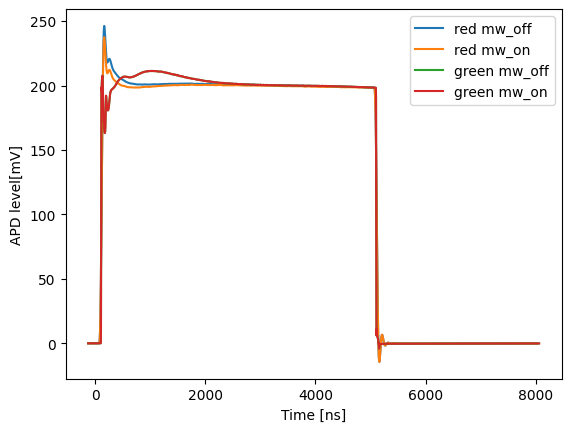

In [17]:
import matplotlib.pyplot as plt
tt = np.arange(-pretrig_size*hcf.SIDIG_timebase, posttrig_size*hcf.SIDIG_timebase, hcf.SIDIG_timebase)
# plt.plot(tt, data_buffer/12a8*1000)
red_bias = np.mean(data_buffer_mw_off[-50:-1, 0])
red_bright = data_buffer_mw_off[:, 0]-red_bias
red_dark = data_buffer_mw_on[:, 0]-red_bias
shift = 20
scale_compen = np.mean(data_buffer_mw_off[:, 0])/np.mean(data_buffer_mw_off[:, 1])
green_bias = np.mean(data_buffer_mw_off[-50:-1, 1])
green_bright = scale_compen*(data_buffer_mw_off[:, 1]-green_bias)
green_dark = scale_compen*(data_buffer_mw_on[:, 1]-green_bias)


plt.plot(tt[:-shift], red_bright[shift:]*1000, label="red mw_off")
plt.plot(tt[:-shift], red_dark[shift:]*1000, label="red mw_on")
plt.plot(tt, green_bright*1000, label="green mw_off")
plt.plot(tt, green_dark*1000, label="green mw_on")
plt.xlabel("Time [ns]")
plt.ylabel("APD level[mV]")
plt.legend()
plt.show()

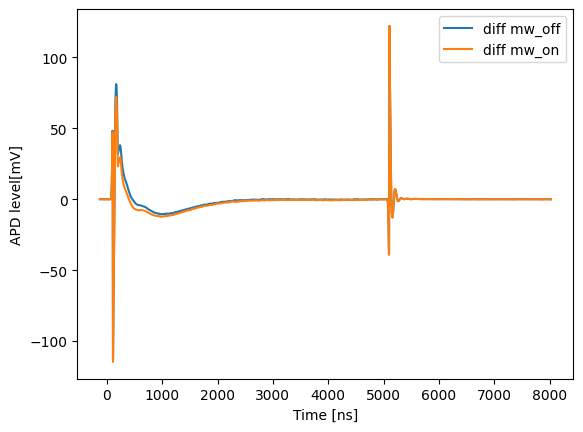

In [18]:
diff_bright =  red_bright[shift:]-green_bright[:-shift]
diff_dark =  red_dark[shift:]-green_bright[:-shift]
plt.plot(tt[:-shift], diff_bright*1000, label="diff mw_off")
plt.plot(tt[:-shift], diff_dark*1000, label="diff mw_on")
plt.xlabel("Time [ns]")
plt.ylabel("APD level[mV]")
plt.legend()
plt.show()


In [21]:
import numpy as np
import plotly.graph_objects as go

# Generate time axis
tt = np.arange(-pretrig_size * hcf.SIDIG_timebase, posttrig_size * hcf.SIDIG_timebase, hcf.SIDIG_timebase)

# Compute biases and scale compensation
red_bias = np.mean(data_buffer_mw_off[-50:-1, 0])
red_bright = data_buffer_mw_off[:, 0] - red_bias
red_dark = data_buffer_mw_on[:, 0] - red_bias

shift = 20
scale_compen = np.mean(data_buffer_mw_off[:, 0]) / np.mean(data_buffer_mw_off[:, 1])
green_bias = np.mean(data_buffer_mw_off[-50:-1, 1])
green_bright = scale_compen * (data_buffer_mw_off[:, 1] - green_bias)
green_dark = scale_compen * (data_buffer_mw_on[:, 1] - green_bias)

# Create the first figure
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=tt[:-shift], y=red_bright[shift:] * 1000, mode='lines', name='red mw_off'))
fig1.add_trace(go.Scatter(x=tt[:-shift], y=red_dark[shift:] * 1000, mode='lines', name='red mw_on'))
fig1.add_trace(go.Scatter(x=tt, y=green_bright * 1000, mode='lines', name='green mw_off'))
fig1.add_trace(go.Scatter(x=tt, y=green_dark * 1000, mode='lines', name='green mw_on'))

fig1.update_layout(
    title="APD Signal Levels",
    xaxis_title="Time [ns]",
    yaxis_title="APD level [mV]",
    legend_title="Signal Type"
)
fig1.show()

# Compute differences
diff_bright = red_bright[shift:] - green_bright[:-shift]
diff_dark = red_dark[shift:] - green_bright[:-shift]

# Create the second figure
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=tt[:-shift], y=diff_bright * 1000, mode='lines', name='diff mw_off'))
fig2.add_trace(go.Scatter(x=tt[:-shift], y=diff_dark * 1000, mode='lines', name='diff mw_on'))

fig2.update_layout(
    title="APD Signal Differences",
    xaxis_title="Time [ns]",
    yaxis_title="APD level [mV]",
    legend_title="Difference Type"
)
fig2.show()


Edges in the floor tuning: [142, 2640]
Edges in the offset tuning: [142, 2640] [115, 2616]
Edges in the floor tuning: [142, 2640]
Edges in the offset tuning: [142, 2640] [115, 2616]
Edges in the floor tuning: [142, 2640]
Edges in the offset tuning: [142, 2640] [115, 2616]
[142, 2640] [115, 2616]
[(1, 4095), (1, 4095)] [(1, 4095), (1, 4095)]


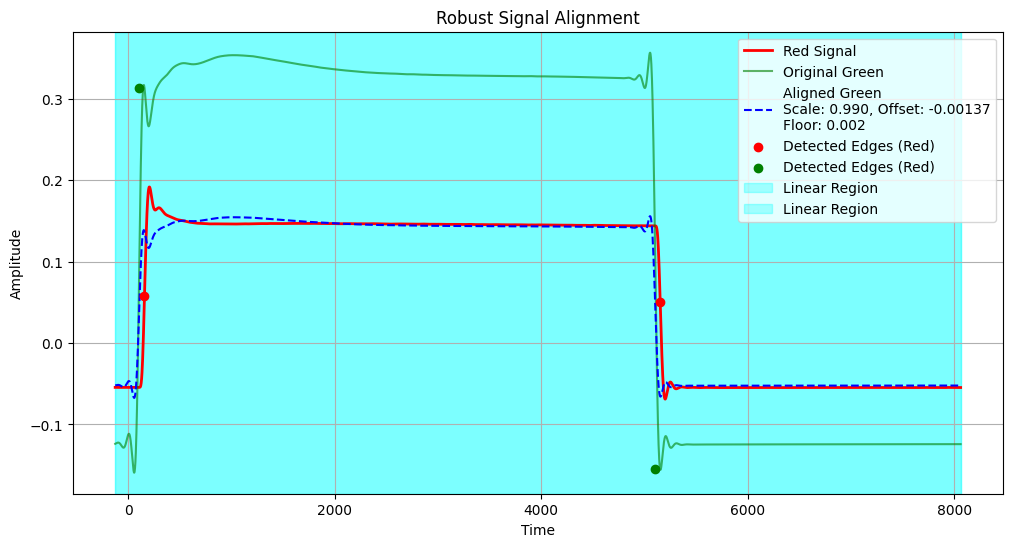

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, find_peaks, correlate
from scipy.optimize import minimize
from scipy.ndimage import shift



def robust_edge_detector(signal, time):
    """ Detects edges and extracts linear transition regions in a rectangular pulse.
    
    Uses robust filtering to ignore noise and adaptively selects parameters.

    Args:
        signal (np.array): The noisy signal.
        time (np.array): Time values corresponding to the signal.

    Returns:
        list: Center indices of the edges.
        list: (start, end) indices of the linear regions for each detected edge.
    """
    N = len(time)  # Total points
    window_length = max(5, N // 50 | 1)  # Adaptive smoothing, must be odd
    polyorder = 2  # Low-order polynomial for noise reduction

    # Smooth the signal
    smooth_signal = savgol_filter(signal, window_length=window_length, polyorder=polyorder)

    # Compute the first derivative (gradient)
    gradient = np.gradient(smooth_signal, time)

    # Find the top N% of slopes, avoiding noise spikes
    sorted_grad = np.sort(np.abs(gradient))
    slope_threshold = np.percentile(sorted_grad, 95)  # Use top 5% as threshold

    # Find where the smoothed signal changes the most (detect peaks in abs(gradient))
    peak_indices, _ = find_peaks(np.abs(gradient), height=slope_threshold, distance=N//10)

    # Filter false edges by ensuring detected points correspond to large signal changes
    edge_indices = []
    for idx in peak_indices:
        if abs(smooth_signal[idx] - smooth_signal[0]) > 0.3 * (max(smooth_signal) - min(smooth_signal)):
            edge_indices.append(idx)

    # Ensure we only detect up to 2 edges (assumes a single pulse)
    edge_indices = sorted(edge_indices)[:2]

    # Find linear regions around each detected edge
    linear_regions = []
    gradient_std = np.std(gradient)  # Use gradient deviation to define linearity
    for center_idx in edge_indices:
        left_idx, right_idx = center_idx, center_idx

        # Expand leftward until gradient deviates too much
        while left_idx > 1 and np.abs(gradient[left_idx] - gradient[left_idx - 1]) < gradient_std:
            left_idx -= 1

        # Expand rightward until gradient deviates too much
        while right_idx < len(time) - 1 and np.abs(gradient[right_idx] - gradient[right_idx + 1]) < gradient_std:
            right_idx += 1

        linear_regions.append((left_idx, right_idx))

    return edge_indices, linear_regions


def floor_shift_optimization(t, red_signal, green_signal):
    """Step 1: Floor shift optimization"""
    red_edges, _ = robust_edge_detector(red_signal, t)
    baseline_mask = (t < 0.1) | (t > 0.9) if len(red_edges) < 2 else (
        (t < red_edges[0] - 0.05) | (t > red_edges[-1] + 0.05)
    )
    
    print("Edges in the floor tuning:", red_edges)
    def floor_cost(floor):
        return np.median(np.abs((green_signal + floor - red_signal)[baseline_mask]))
    
    floor_result = minimize(floor_cost, 0.0, method='Powell', 
                           options={'xtol': 1e-6, 'ftol': 1e-6})
    green_floor_adj = green_signal + floor_result.x[0]
    
    return green_floor_adj, floor_result.x[0]

def scaling_optimization(t, red_signal, green_floor_adj):
    """Step 2: Scaling optimization"""
    def scale_cost(scale):
        scaled_green = scale * green_floor_adj
        return np.mean((scaled_green - red_signal)**2)
    
    scale_result = minimize(scale_cost, 1.0, method='L-BFGS-B', 
                           bounds=[(0.5, 2.0)], 
                           options={'maxiter': 1000, 'ftol': 1e-9})
    green_scaled_adj = scale_result.x[0] * green_floor_adj
    
    return green_scaled_adj, scale_result.x[0]

def offset_tuning_optimization(t, red_signal, green_scaled_adj):
    """Step 3: Offset tuning optimization"""
    red_edges, red_linear_portions = robust_edge_detector(red_signal, t)
    green_edges, green_linear_portions = robust_edge_detector(green_scaled_adj, t)
    print("Edges in the offset tuning:", red_edges, green_edges)
    # Handle cases with 1 or 2 edges
    if len(red_edges) >= 1 and len(green_edges) >= 1:
        # Use the linear portion around the edges for optimization
        edge_mask = np.zeros_like(t, dtype=bool)
        for portion in green_linear_portions:
            edge_mask |= (t >= portion[0]) & (t <= portion[1])
    else:
        # No edges detected: use the entire signal
        edge_mask = np.ones_like(t, dtype=bool)
    
    def offset_cost(offset):
        shifted_green = shift(green_scaled_adj, -offset/(t[1]-t[0]), order=3, mode='nearest')
        return np.mean((shifted_green[edge_mask] - red_signal[edge_mask])**2)
    
    offset_result = minimize(offset_cost, 0.0, method='L-BFGS-B', 
                            bounds=[(-0.1, 0.1)], 
                            options={'maxiter': 1000, 'ftol': 1e-9})
    green_offset_adj = shift(green_scaled_adj, -offset_result.x[0]/(t[1]-t[0]), order=3, mode='nearest')
    
    return green_offset_adj, offset_result.x[0]


def integrated_optimization(t, red_signal, green_offset_adj, initial_params):
    """Step 4: Integrated optimization"""

    red_edges, red_linear_portions = robust_edge_detector(red_signal, t)
    green_edges, green_linear_portions = robust_edge_detector(green_offset_adj, t)
    # print("Edges in the final optimization:", red_edges, green_edges)
    # if len(red_edges) >= 2 and len(green_edges) >= 2:
    #     edge_mask = (t >= red_edges[0] - 0.05) & (t <= red_edges[-1] + 0.05)
    # else:
    #     edge_mask = np.ones_like(t, dtype=bool)
    # Handle cases with 1 or 2 edges
    if len(red_edges) >= 1 and len(green_edges) >= 1:
        # Use the linear portion around the edges for optimization
        edge_mask = np.zeros_like(t, dtype=bool)
        for portion in green_linear_portions:
            edge_mask |= (t >= portion[0]) & (t <= portion[1])
    else:
        # No edges detected: use the entire signal
        edge_mask = np.ones_like(t, dtype=bool)
        
    def integrated_cost(params):
        floor, scale, offset = params
        adjusted_green = scale * shift(green_offset_adj + floor, -offset/(t[1]-t[0]), order=3, mode='nearest')
        return np.mean((adjusted_green - red_signal)**2)
    
    result = minimize(integrated_cost, initial_params, method='L-BFGS-B', 
                      bounds=[(-1.0, 1.0), (0.5, 2.0), (-0.1, 0.1)], 
                      options={'maxiter': 1000, 'ftol': 1e-9})
    
    floor_opt, scale_opt, offset_opt = result.x
    green_integrated_adj = scale_opt * shift(green_offset_adj + floor_opt, -offset_opt/(t[1]-t[0]), order=3, mode='nearest')
    
    return green_integrated_adj, floor_opt, scale_opt, offset_opt

def align_signals(t, red_signal, green_signal):
    # Step 1: Floor shift optimization
    green_floor_adj, floor_shift = floor_shift_optimization(t, red_signal, green_signal)
    
    # Step 2: Scaling optimization
    green_scaled_adj, scale_opt = scaling_optimization(t, red_signal, green_floor_adj)
    
    # Step 3: Offset tuning optimization
    green_offset_adj, offset_opt = offset_tuning_optimization(t, red_signal, green_scaled_adj)
    
    # Step 4: Integrated optimization
    initial_params = [floor_shift, scale_opt, offset_opt]
    green_integrated_adj, floor_opt, scale_opt, offset_opt = integrated_optimization(t, red_signal, green_offset_adj, initial_params)
    
    return scale_opt, offset_opt, floor_opt, green_integrated_adj

def iterative_alignment(t, red_signal, green_signal, max_iter=3):
    for _ in range(max_iter):
        floor, scale, offset, green_signal = align_signals(t, red_signal, green_signal)
    return floor, scale, offset, green_signal

# Plotting code remains the same
red_bright = data_buffer_mw_off[:, 0] 
green_bright = data_buffer_mw_off[:, 1] 
t, red, green = tt, red_bright, green_bright

scale, offset, floor, adj_green = iterative_alignment(t, red, green)

plt.figure(figsize=(12, 6))
plt.plot(t, red, 'r', label='Red Signal', lw=2)
plt.plot(t, green, 'g', alpha=0.6, label='Original Green')
plt.plot(t, adj_green, 'b--', lw=1.5, 
         label=f'Aligned Green\nScale: {scale:.3f}, Offset: {offset:.5f}\nFloor: {floor:.3f}')

red_edges, red_edges_linear = robust_edge_detector(red_bright, t)
green_edges, green_edges_linear = robust_edge_detector(green_bright, t)
print(red_edges, green_edges)
print(red_edges_linear, green_edges_linear)
plt.scatter(tt[red_edges], red_bright[red_edges], color='red', marker='o', label="Detected Edges (Red)", zorder=3)
plt.scatter(tt[green_edges], green_bright[red_edges], color='green', marker='o', label="Detected Edges (Red)", zorder=3)
# Highlight linear regions
# for start, end in red_edges_linear:
#     plt.axvspan(tt[start], tt[end], color='yellow', alpha=0.3, label="Linear Region" if start == red_edges_linear[0][0] else "")
for start, end in green_edges_linear:
    plt.axvspan(tt[start], tt[end], color='cyan', alpha=0.3, label="Linear Region" if start == red_edges_linear[0][0] else "")


plt.xlabel('Time'), plt.ylabel('Amplitude')
plt.title('Robust Signal Alignment'), plt.legend(), plt.grid(True)
plt.show()

In [37]:
t[red_edges]

array([7900, 8000])

In [20]:
def contrast_math(sig,bg,start,stop):
    sig_subset = sig[start:stop]
    bg_subset = bg[start:stop]
    sig_mean = np.mean(sig_subset, axis=0)
    bg_mean = np.mean(bg_subset, axis=0)

    contrast = sig_mean/bg_mean 


    return contrast
